<a href="https://colab.research.google.com/github/quimHM/QHM_TFG_repository/blob/main/MAB_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

#https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits

In [1]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
import random
%matplotlib inline

In [7]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=0.1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = self.var * np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [2]:
class PowerSocketProb:
    """ the base power socket class """
    
    def __init__(self, q, cl):                
        self.q = q        # the true reward value 
        self.confidence_level = cl  
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = 100 * np.random.binomial(1,self.q)     
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [27]:
#class PowerSocketTrue:
    """ the base power socket class """
    
    def __init__(self, q, cl):                
        self.q = q        # the true reward value 
        self.confidence_level = cl  
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = 100 * self.q[self.n]
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [3]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

# return the index of the smallest value in the supplied list
# - arbitrarily select between the smallest values in the case of a tie
# (the standard np.argmin just chooses the first value in the case of a tie)
def random_argmin(value_list):
  """ a random tie-breaking argmin"""
  values = np.asarray(value_list)
  return np.argmin(np.random.random(values.shape) * (values==values.min()))


In [4]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        # self.sockets = [socket(q, confidence_level) for q in socket_order]     
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]

        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        return self.total_steps, self.total_reward
  

In [ ]:
def mus_and_devs_random():
  devs = []
  mus = []
  for i in range(8):
    d = round(random.uniform(5.0,15.0),2)
    m = round(random.uniform(70.0,100.0),2)
    devs.append(d)
    mus.append(m)
  return mus,devs

In [ ]:
def mus_and_devs():
  devs = [10.0]*8
  mus = []
  for i in range(8):
    m = 100.0-i*5.0
    mus.append(m)
  return mus,devs

In [ ]:
#mus,devs = mus_and_devs_random()
mus,devs = mus_and_devs()

#devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
#mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]

print(devs)
print(mus)
test = SocketTester(PowerSocket, mus, devs, 5)
test.run(1000)
test.get_number_of_trials()[-1]

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[100.0, 95.0, 90.0, 85.0, 80.0, 75.0, 70.0, 65.0]


array([969.,  24.,   1.,   1.,   1.,   1.,   2.,   1.])

In [ ]:
class SocketTesterBatch():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [ ]:
devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
#mus,devs = mus_and_devs()
test2 = SocketTesterBatch(PowerSocket, mus, devs, 10)

decisions = random.choices(range(8), k=1000)
decisions = []
for i in range(8):
  for j in range(125):
    decisions.append(i)
#decisions = [[125]]*8
ts,tr,_ = test2.run(decisions)

Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 99.2, 100.0, 100.0]
Percentage over total selected (%): [12.51, 12.51, 12.51, 12.51, 12.51, 12.41, 12.51, 12.51]


In [ ]:
ts,tr,_ = test2.run(decisions, 0.5)

Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
Relative approval rate (%): [100.0, 100.0, 0.8, 3.2, 72.8, 2.4, 100.0, 20.8]
Percentage over total selected (%): [25.0, 25.0, 0.2, 0.8, 18.2, 0.6, 25.0, 5.2]


In [ ]:
#sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
#devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
#mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
weights_m = []
for m in mus:
  weights_m.append((m*m*m*m*m*m*m*m*m)/1000*(m*m*m*m*m*m*m*m*m)/1000)
sample_bias_decisions = random.choices(range(8),weights=weights_m,k=1000)
print(sample_bias_decisions)
ts,tr,_ = test2.run(sample_bias_decisions, 0.8)

[6, 7, 7, 1, 6, 1, 1, 6, 1, 1, 0, 6, 7, 6, 4, 7, 1, 0, 6, 4, 6, 3, 0, 6, 1, 6, 0, 1, 6, 6, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 7, 0, 6, 1, 6, 1, 1, 1, 2, 6, 6, 0, 0, 6, 6, 1, 2, 1, 6, 6, 7, 6, 1, 1, 6, 6, 4, 7, 1, 6, 2, 4, 7, 6, 2, 6, 0, 6, 1, 3, 6, 1, 2, 7, 1, 1, 1, 0, 2, 1, 1, 4, 6, 7, 0, 6, 1, 2, 6, 1, 4, 7, 6, 1, 1, 6, 2, 0, 1, 0, 1, 6, 4, 1, 6, 6, 4, 1, 6, 4, 7, 6, 1, 0, 2, 1, 1, 6, 2, 1, 1, 6, 6, 2, 4, 2, 1, 1, 1, 2, 0, 7, 4, 7, 1, 0, 7, 1, 1, 1, 6, 6, 1, 7, 6, 4, 1, 6, 6, 4, 1, 1, 0, 7, 6, 6, 0, 1, 1, 4, 2, 2, 1, 2, 1, 7, 6, 1, 1, 4, 7, 6, 0, 6, 0, 1, 4, 4, 4, 4, 0, 1, 6, 6, 3, 7, 1, 4, 4, 4, 7, 6, 1, 3, 1, 2, 0, 0, 6, 1, 1, 1, 6, 6, 4, 1, 6, 7, 0, 1, 6, 1, 1, 7, 7, 7, 1, 6, 1, 0, 6, 1, 4, 7, 7, 0, 6, 6, 2, 1, 1, 0, 7, 6, 0, 1, 1, 0, 1, 2, 6, 6, 4, 7, 6, 0, 6, 1, 6, 0, 7, 1, 4, 1, 6, 2, 4, 1, 7, 1, 7, 1, 0, 1, 1, 2, 2, 6, 2, 1, 6, 7, 7, 1, 6, 1, 7, 1, 0, 1, 6, 2, 1, 7, 1, 6, 6, 1, 6, 1, 7, 1, 2, 0, 1, 6, 6, 6, 1, 7, 6, 1, 2, 6, 6, 1, 6, 6, 1, 0, 1, 6, 6, 6, 7, 1, 6, 6, 2, 6, 0, 6, 

In [ ]:
a=np.array([9.7, 36.7, 5.6, 0.9, 7.2, 0.1, 29.3, 10.5])
#b=np.array([12.12, 45.88, 2.0, 1.12, 0.25, 0.12, 36.62, 1.88])
b=np.array([12.12, 45.88, 0.75, 0.25, 1.38, 0.12, 36.62, 2.88])


diff = np.subtract(b,a)
print(diff)
diff = np.divide(diff,a)
print(diff)

[ 2.42  9.18 -4.85 -0.65 -5.82  0.02  7.32 -7.62]
[ 0.24948454  0.25013624 -0.86607143 -0.72222222 -0.80833333  0.2
  0.24982935 -0.72571429]


###**NON-STATIC**

In [ ]:
#def f(probs, val, ind):
#    probs[ind] += val
#    mask = np.ones(len(probs), bool)
#    mask[ind] = False
#    probs[mask] -= val / (len(probs) - 1)
#    return np.clip(probs, 0, np.infty) / np.sum(np.clip(probs, 0, np.infty))

In [ ]:
def cummulative_sample(tester,iter,orig,coef):
  instances_distribution = np.array(orig)
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
      print(i)
      #print(list(instances_distribution))
      pbool=True

    decisions = random.choices(range(8),weights=list(instances_distribution),k=5000)
    ts,tr,ti = tester.run(decisions, 0.8, pbool)
    
    #for i in range(len(ti)):
    #  instances_distribution = f(instances_distribution,ti[i],i)
    instances_distribution = np.add(instances_distribution,ti*coef*100)
    instances_distribution = np.clip(instances_distribution,0,None)
    instances_distribution = instances_distribution / instances_distribution.sum()

In [ ]:
o_sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
#o_sample_bias = weights_m
cummulative_sample(test2,35,o_sample_bias,0.001)

0
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [55.66, 23.04, 2.22, 0.94, 9.34, 8.42, 0.22, 0.16]
Relative approval rate (%): [95.62, 100.0, 67.57, 8.51, 18.63, 0.48, 100.0, 100.0]
Percentage over total selected (%): [66.53, 28.8, 1.88, 0.1, 2.17, 0.05, 0.27, 0.2]
9
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [30.44, 40.32, 0.0, 0.0, 0.0, 0.0, 19.58, 9.66]
Relative approval rate (%): [58.41, 100.0, 0.0, 0.0, 0.0, 0.0, 100.0, 24.02]
Percentage over total selected (%): [22.22, 50.4, 0.0, 0.0, 0.0, 0.0, 24.48, 2.9]
18
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 87.86, 0.0, 0.0, 0.0, 0.0, 12.14, 0.0]
Relative approval rate (%): [0.0, 84.34, 0.0, 0.0, 0.0, 0.0, 48.6, 0.0]
Percentage over total selected (%): [0.0, 92.62, 0.0, 0.0, 0.0, 0.0, 7.38, 0.0]
27
Reward distribution: [92.1, 98.48, 88.49, 80

In [ ]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,35,no_sample_bias,0.05)

0
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.56, 12.4, 12.2, 12.88, 11.98, 12.44, 12.38, 13.16]
Relative approval rate (%): [100.0, 100.0, 100.0, 36.49, 100.0, 4.98, 100.0, 100.0]
Percentage over total selected (%): [15.7, 15.5, 15.25, 5.88, 14.98, 0.78, 15.48, 16.45]
9
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Relative approval rate (%): [0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Percentage over total selected (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Relative approval rate (%): [0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Percentage over total selected (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


KeyboardInterrupt: ignored

In [ ]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,150,no_sample_bias,0.05)

In [ ]:
def nonstatic(iter, rewards_d_o_mu, rewards_d_o_dev, r_coef, instances_d_o, i_coef):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatch(PowerSocket, list(rewards_d), rewards_d_o_dev, 10)
    decisions = random.choices(range(8),weights=list(instances_d),k=5000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [ ]:
#nonstatic(500, rewards_bias, devs_nonbias, 0.001, instances_bias, 0.001)

In [ ]:
#nonstatic(2500, rewards_nonbias, 0, instances_bias, 0.01)

In [ ]:
#nonstatic(100, rewards_bias, 0, instances_nonbias, 0)

In [ ]:
#nonstatic(100, rewards_bias, 0.1, instances_nonbias, 0)

In [ ]:
#nonstatic(100, rewards_bias, 0, instances_bias, 0.01)

In [ ]:
#nonstatic(100, rewards_bias, 0.01, instances_bias, 0)

In [ ]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0.01)

###**SOLUTION?**

In [5]:
class SocketTesterBatchSOLUTION():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def bias_presence_hipo(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          selected_presence = np.array(pulled/(t+1))
          diff = np.subtract(selected_presence, presence)
          #diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        #return random_argmin(bias_list)
        return bias_list

    def bias_presence_step(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.socket_stats[:,:,1][t]/t)
        diff = np.subtract(selected_presence, presence)
        #diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_presence(self):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        abs = np.abs(diff)
        return np.sum(abs) 

    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          overall_percentages = np.mean(curr_percentages)
          diff = np.subtract(overall_percentages,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        #return random_argmin(bias_list)
        return bias_list

    def bias_rate_step(self, t):
        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(curr_percentages)
        diff = np.subtract(overall_percentages,curr_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = self.capping #np.mean(curr_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 
    """
    def select_socket( self, t ):
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = self.capping #np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index
    """
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 
        socket_max_index = self.sockets.index(available_sockets[socket_max])

        #print(self.bias_presence_hipo(t))
        socket_min = random_argmin([self.bias_presence_hipo(t)[socket] for socket in available]) 
        #print([self.bias_presence_hipo(t)[socket] for socket in available][socket_min])
        socket_min_index = self.sockets.index(available_sockets[socket_min])
        #print(self.bias_presence_hipo(t)[socket_min_index])

        return_index = random.choices([socket_min_index,socket_max_index],cum_weights=[self.subopt_coef,1])
        #print(socket_min_index,socket_max_index,"->",return_index[0])
        return return_index[0]     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        self.capping = max_percent_decisions
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        self.approval_rates = [round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))]
        if(prints_bool):
          #print("possibles",self.possibles)
          print("Reward distribution:",[round(s.q,2) for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",self.approval_rates)
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          print("Total reward:",self.total_reward,"|| and presence bias:",self.final_bias_presence())
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))
        return_dic = {
            "total_steps":self.total_steps,
            "total_reward":self.total_reward,
            "increments":self.return_increments(decisions_to_consider),
            "bias_presence":self.final_bias_presence(),
            "percentages":self.approval_rates
        }
        return return_dic
  

In [8]:
rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])
rewards_nonbias = [0.8]*8
devs_nonbias = [0]*8

instances_bias = np.array([0.535, 0.24, 0.023, 0.011, 0.087, 0.081, 0.011, 0.011])
instances_nonbias = [1/8]*8

sol_test = SocketTesterBatchSOLUTION(PowerSocket, rewards_bias, devs_nonbias, 0.05, 0)
decisions = random.choices(range(8),weights=list(instances_bias),k=5000)
rd = sol_test.run(decisions, 0.8, True)

Reward distribution: [0.86, 0.82, 0.83, 0.8, 0.71, 0.66, 0.75, 0.67]
Presence of each in batch (%): [55.36, 24.36, 2.16, 1.0, 8.36, 8.54, 0.14, 0.08]
Relative approval rate (%): [100.0, 88.67, 100.0, 72.0, 0.48, 0.23, 57.14, 25.0]
Percentage over total selected (%): [69.18, 26.99, 2.7, 0.9, 0.05, 0.02, 0.1, 0.02]
Total reward: 3377.678500000035 || and presence bias: 0.34015556110972256


In [ ]:
"""
    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          #overall_percentages = np.mean(curr_percentages)
          #diff = np.subtract(overall_percentages,curr_percentages)
          diff = np.subtract(self.capping,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_rate_step(self, t):
        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])
        #overall_percentages = np.mean(curr_percentages)
        #diff = np.subtract(overall_percentages,curr_percentages)
        diff = np.subtract(self.capping,curr_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(final_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 
"""

'\n    def bias_rate_hipo(self, t):\n        bias_list = []\n        for c in range(len(self.sockets)):\n          pulled = self.socket_stats[:,:,1][t].copy()\n          pulled[c]+=1\n          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])\n          #overall_percentages = np.mean(curr_percentages)\n          #diff = np.subtract(overall_percentages,curr_percentages)\n          diff = np.subtract(self.capping,curr_percentages)\n          abs = np.abs(diff)\n          bias_list.append(np.sum(abs))\n        return bias_list\n\n    def bias_rate_step(self, t):\n        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])\n        #overall_percentages = np.mean(curr_percentages)\n        #diff = np.subtract(overall_percentages,curr_percentages)\n        diff = np.subtract(self.capping,curr_percentages)\n        abs = np.abs(diff)\n        return np.sum(abs) \n\n    def final_bias_r

In [177]:
class SocketTesterBatchSOLUTIONProb():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def bias_presence_hipo(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.get_number_of_trials()[t].copy()
          pulled[c]+=1
          selected_presence = np.array(pulled/(t+1))
          diff = np.subtract(selected_presence, presence)
          #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list
    
    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          overall_percentages = np.mean(curr_percentages)
          diff = np.subtract(overall_percentages,curr_percentages)
          #diff = np.subtract(self.capping,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_posteriors_hipo(self, t):
        #P(c in C_i | c is approved ) = P( c is approved | c in C_i ) * P( c in C_i ) / P( c is approved )
        A = np.array([i/sum(self.possibles) for i in self.possibles])
        B = self.capping
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.get_number_of_trials()[t].copy()
          pulled[c]+=1
          B_A = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          A_B = np.divide(np.multiply(B_A,A),B, out=np.zeros_like(np.multiply(B_A,A)), where=B!=0)
          #print(A_B)
          diff = np.subtract(np.mean(A_B),A_B)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_presence_step(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_number_of_trials()[t]/t)
        diff = np.subtract(selected_presence, presence)
        #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_presence(self):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        abs = np.abs(diff)
        return np.sum(abs) 
    
    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(final_percentages)
        #print(overall_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs)

    def final_bias_posteriors(self):
        #P(c in C_i | c is approved ) = P( c is approved | c in C_i ) * P( c in C_i ) / P( c is approved )
        B_A = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        A = np.array([i/sum(self.possibles) for i in self.possibles])
        B = self.total_steps/sum(self.possibles)
        A_B = np.divide(np.multiply(B_A,A),B, out=np.zeros_like(np.multiply(B_A,A)), where=B!=0)
        #print(A_B)
        diff = np.subtract(np.mean(A_B),A_B)
        abs = np.abs(diff)
        return np.sum(abs)

    def punishing_term(self,bias_func,t):
        b_list = bias_func(t)
        norm_num = np.subtract(b_list,max(b_list))
        norm_denom = np.subtract(max(b_list),min(b_list))
        aux_b_list = np.divide(norm_num,norm_denom, out=np.zeros_like(norm_num), where=norm_denom!=0)
        return np.multiply(aux_b_list,100)

    def select_socket( self, t ):
              
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        bias_term = self.punishing_term(self.bias_presence_hipo,t)
        #print([self.sockets[i].sample(t+1)for i in range(8)])
        #print(bias_term)
        #print()
        socket_max = random_argmax([(1-self.subopt_coef)*self.sockets[socket].sample(t+1)-self.subopt_coef*bias_term[socket] for socket in available]) 

        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index
    
    def select_socket_candidates( self, t ):
        """ Greedy Socket Selection"""
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 
        socket_max_index = self.sockets.index(available_sockets[socket_max])

        socket_min = random_argmin([self.bias_presence_hipo(t)[socket] for socket in available]) 
        socket_min_index = self.sockets.index(available_sockets[socket_min])

        return_index = random.choices([socket_min_index,socket_max_index],cum_weights=[self.subopt_coef,1])
        #print(socket_min_index,socket_max_index,"(",self.subopt_coef,")->",return_index[0])
        return return_index[0]     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff1 = np.add(1,diff)
        #diff2 = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        #diff2 = np.add(1,diff2)
        #print(diff1,diff2)
        #print(diff.sum())
        return diff1
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        self.capping = max_percent_decisions
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)
        self.bias_hist = []
        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):
            self.socket_stats[t] = self.get_socket_stats(t)     
            socket_index = self.select_socket(t)
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              if usos > usos_maxims:
                  break
            
            if t%10==0:
              self.bias_hist.append(self.bias_presence_step(t))

        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        self.approval_rates = [round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))]
        self.regret = 100*max([s.q for s in self.sockets])-self.get_mean_reward()
        #print(self.regret)
        if(prints_bool):
          #print("possibles",self.possibles)
          print("Reward distribution:",[round(s.q,4) for s in self.sockets])
          print("Final estimates:",[round(e/100,4) for e in self.get_estimates()[self.total_steps]])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",self.approval_rates)
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          print("Total reward:",self.total_reward,"|| and presence bias:",self.final_bias_presence())
          print("Rate bias:",self.final_bias_rate())
          print("Posteriors bias:",self.final_bias_posteriors())
          print("Final regret:",self.regret)
          #print(self.return_increments(decisions_to_consider))
        return_dic = {
            "total_steps":self.total_steps,
            "total_reward":self.total_reward,
            "increments":self.return_increments(decisions_to_consider),
            "estimates":[e/100 for e in self.get_estimates()[self.total_steps]],
            "bias_presence":self.final_bias_presence(),
            "bias_rate":self.final_bias_rate(),
            "bias_posteriors":self.final_bias_posteriors(),
            "app_rate":self.approval_rates,
            "percentages":self.get_socket_percentages(),
            "bias_hist":self.bias_hist,
            "regret":self.regret
        }
        return return_dic

In [116]:
#rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])
rewards_nonbias = [0.8]*8
devs_nonbias = [0]*8

instances_bias = np.array([0.535, 0.24, 0.023, 0.011, 0.087, 0.081, 0.011, 0.011])
instances_nonbias = [1/8]*8

In [156]:
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)

0.031897627965037145
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8623, 0.8577, 0.8, 0.8333, 0.0, 0.5, 0.5, 0.5]
Presence of each in batch (%): [51.9, 26.0, 2.0, 1.2, 8.1, 8.0, 1.4, 1.4]
Relative approval rate (%): [96.53, 100.0, 100.0, 100.0, 1.23, 2.5, 14.29, 14.29]
Percentage over total selected (%): [62.55, 32.46, 2.5, 1.5, 0.12, 0.25, 0.25, 0.25]
Total reward: 68500 || and presence bias: 0.35927340823970033
Rate bias: 3.6422579543485134
Posteriors bias: 1.4007490636704119


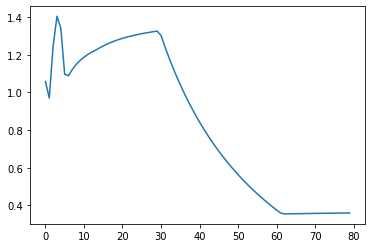

In [172]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

4.151747815230962
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8516, 0.8333, 0.6, 0.8333, 0.7284, 0.725, 0.8571, 0.5714]
Presence of each in batch (%): [51.9, 26.0, 2.0, 1.2, 8.1, 8.0, 1.4, 1.4]
Relative approval rate (%): [100.0, 23.08, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [64.79, 7.49, 2.5, 1.5, 10.11, 9.99, 1.75, 1.75]
Total reward: 65200 || and presence bias: 0.36893882646691634
Rate bias: 1.3461538461538463
Posteriors bias: 1.0461922596754059


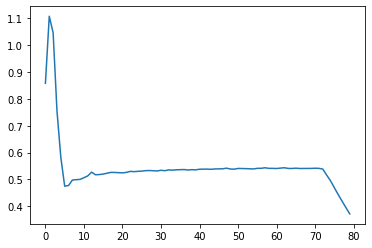

In [173]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.25)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

5.4001872659175945
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8241, 0.8462, 0.875, 0.8, 0.6923, 0.6562, 0.6364, 0.6364]
Presence of each in batch (%): [51.9, 26.0, 2.0, 1.2, 8.1, 8.0, 1.4, 1.4]
Relative approval rate (%): [79.96, 80.0, 80.0, 83.33, 80.25, 80.0, 78.57, 78.57]
Percentage over total selected (%): [51.81, 25.97, 2.0, 1.25, 8.11, 7.99, 1.37, 1.37]
Total reward: 64200 || and presence bias: 0.002514357053682855
Rate bias: 0.06818209621677818
Posteriors bias: 1.0561797752808988


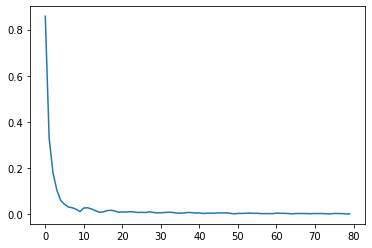

In [176]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.5)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

3.527528089887639
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8458, 0.8317, 0.75, 0.8, 0.7846, 0.6875, 0.7273, 0.8182]
Presence of each in batch (%): [51.9, 26.0, 2.0, 1.2, 8.1, 8.0, 1.4, 1.4]
Relative approval rate (%): [79.96, 80.0, 80.0, 83.33, 80.25, 80.0, 78.57, 78.57]
Percentage over total selected (%): [51.81, 25.97, 2.0, 1.25, 8.11, 7.99, 1.37, 1.37]
Total reward: 65700 || and presence bias: 0.002514357053682855
Rate bias: 0.06818209621677818
Posteriors bias: 1.0561797752808988


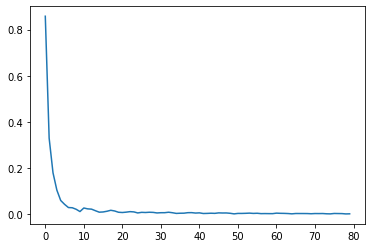

In [175]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.75)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

1.4051810237203455
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8555, 0.8077, 0.9, 1.0, 0.0, 0.0, 0.0, 0.0]
Presence of each in batch (%): [51.9, 26.0, 2.0, 1.2, 8.1, 8.0, 1.4, 1.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 8.33, 0.0, 0.0, 0.0, 0.0]
Percentage over total selected (%): [64.79, 32.46, 2.5, 0.12, 0.0, 0.0, 0.0, 0.0]
Total reward: 67400 || and presence bias: 0.3982546816479401
Rate bias: 3.6875
Posteriors bias: 1.445692883895131


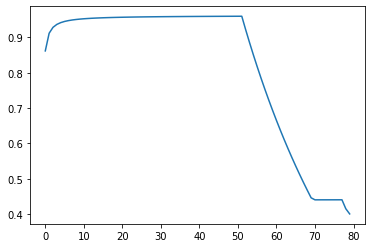

In [174]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 1)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [178]:
rwd_results = []
presence_results = []
rate_results = []
posteriors_results = []
regret_results = []
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
for sopt in np.arange(0,1.1,0.1):
  sopt_i_rwd_results = []
  sopt_i_presence_results = []
  sopt_i_rate_results = []
  sopt_i_posteriors_results = []
  sopt_i_regret_results = []
  sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, sopt)
  for iter in range(25):
    rd = sol_test.run(decisions, 0.8, False)
    sopt_i_rwd_results.append(rd["total_reward"])
    sopt_i_presence_results.append(rd["bias_presence"])
    sopt_i_rate_results.append(rd["bias_rate"])
    sopt_i_posteriors_results.append(rd["bias_posteriors"])
    sopt_i_regret_results.append(rd["regret"])
  rwd_results.append([np.mean(sopt_i_rwd_results),np.std(sopt_i_rwd_results)])
  presence_results.append([np.mean(sopt_i_presence_results),np.std(sopt_i_presence_results)])
  rate_results.append([np.mean(sopt_i_rate_results),np.std(sopt_i_rate_results)])
  posteriors_results.append([np.mean(sopt_i_posteriors_results),np.std(sopt_i_posteriors_results)])
  regret_results.append([np.mean(sopt_i_regret_results),np.std(sopt_i_regret_results)])
print([rwd_results[i][0] for i in range(len(rwd_results))])
print([presence_results[i][0] for i in range(len(presence_results))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in double_scalars


[66528.0, 66800.0, 66440.0, 65740.0, 65524.0, 64920.0, 65996.0, 65288.0, 65460.0, 65256.0, 67456.0]
[0.30760279650436956, 0.30645153558052435, 0.25032409488139823, 0.17075475655430708, 0.06906017478152314, 0.002851335830212324, 0.002714007490636794, 0.002701622971285983, 0.002701622971285983, 0.002701622971285983, 0.3987515605493133]


In [169]:
print([regret_results[i][0] for i in range(len(regret_results))])
#print([bias_results[i][0] for i in range(len(bias_results))])

[]


In [179]:
import matplotlib.pyplot as plt
import numpy as np

xr = np.arange(0,1.1,0.1)
yr = [rwd_results[i][0] for i in range(len(rwd_results))]
er = [rwd_results[i][1] for i in range(len(rwd_results))]

xpres = np.arange(0,1.1,0.1)
ypres = [presence_results[i][0] for i in range(len(presence_results))]
epres = [presence_results[i][1] for i in range(len(presence_results))]

xrate = np.arange(0,1.1,0.1)
yrate = [rate_results[i][0] for i in range(len(rate_results))]
erate = [rate_results[i][1] for i in range(len(rate_results))]

xpost = np.arange(0,1.1,0.1)
ypost = [posteriors_results[i][0] for i in range(len(posteriors_results))]
epost = [posteriors_results[i][1] for i in range(len(posteriors_results))]

xregr = np.arange(0,1.1,0.1)
yregr = [regret_results[i][0] for i in range(len(regret_results))]
eregr = [regret_results[i][1] for i in range(len(regret_results))]

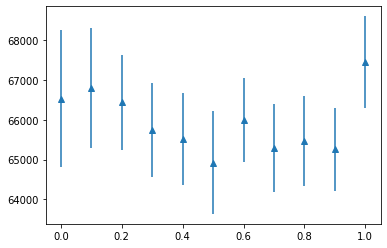

In [180]:
plt.errorbar(xr, yr, er, linestyle='None', marker='^')
plt.show() #total rewards (y) vs subopt value (x)

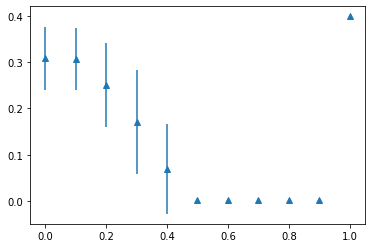

In [181]:
plt.errorbar(xpres, ypres, epres, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

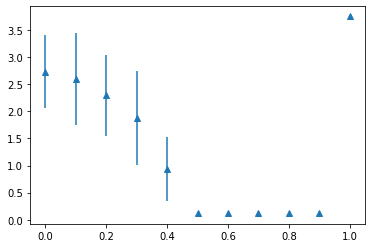

In [182]:
plt.errorbar(xrate, yrate, erate, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

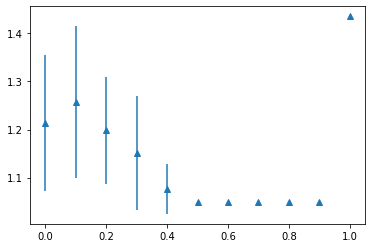

In [183]:
plt.errorbar(xpost, ypost, epost, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

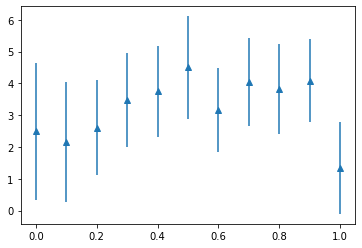

In [184]:
plt.errorbar(xregr, yregr, eregr, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

In [ ]:
ma = np.mean([0,0,1,0])
mb = np.mean([0,0,1,1])
mc = np.mean([0,0,1,0,0,0,1,1])
md = (ma+mb)/2
print(ma,mb,mc,md)

In [ ]:
r_coef = 0.5
old_r_term = np.multiply([0.25],1-r_coef)
new_r_term = np.multiply([0.5],r_coef)
rewards_d = np.add(old_r_term,new_r_term)
rewards_d = np.clip(rewards_d,0,1)
print(rewards_d)

curr_percentages = self.socket_stats[:,:,1][t]/t
mean_percentages = np.mean(curr_percentages)
dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

mean_selections = np.mean(self.get_number_of_trials()[t])
dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

#DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
//dif = dif_percentages #rang 10-30-50

dif = dif_selections   #rang 0-0.01-0.1

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [32]:
def plot_values(m, trend=False):
  x = range(len(m))
  for i in range(len(m[0])):
    y = [m[j][i] for j in range(len(m))]
    plt.plot(x, y)
    if(trend):
      z = np.polyfit(x, y, 1)
      p = np.poly1d(z)
      plt.plot(x, p(x), color = colors[i], linestyle="--")
  plt.show()

In [31]:
def plot_percen(m):
  x = range(len(m))
  y = np.array([m[j][0] for j in range(len(m))])
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(x,y)
  Y = [y]
  for i in range(1,len(m[0])):
    ax.bar(x, [m[j][i] for j in range(len(m))], bottom=y)
    y = np.add(y,np.array([m[j][i] for j in range(len(m))]))
  plt.show()

In [245]:
def nonstatic_sol(iter, rewards_d_o_mu, r_coef, instances_d_o, i_coef, sub_opt):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  rewards_his = []
  instances_hist = [] 
  percentages_hist = []
  bias_hist = []

  for i in range(iter):
    pbool=False
    #if(i%math.ceil(iter/4)==0 or i==iter-1):
    if(i==0 or i==iter-1):
        print(i)
        pbool=True

    if(i%math.ceil(iter/20)==0 or i==iter-1):
      rewards_his.append(rewards_d)
      instances_hist.append(instances_d)

    updated_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, list(rewards_d), 10, sub_opt)
    decisions = random.choices(range(8),weights=list(instances_d),k=1000)
    rd = updated_test.run(decisions, 0.8, pbool)

    #if(i%math.ceil(iter/25)==0 or i==iter-1):
    percentages_hist.append(rd["percentages"])

    bias_hist.append([rd["bias_presence"],rd["bias_rate"],rd["bias_posteriors"],rd["regret"]])

    r_update = rd["estimates"]
    i_update = rd["increments"]

    #aux_update = rd["app_rate"]
    #aux_term = np.add(np.divide(np.subtract(aux_update,r_update),rewards_d,out=np.zeros_like(r_update), where=r_update!=0),1)

    old_r_term = np.multiply(rewards_d,1-r_coef)
    new_r_term = np.multiply(np.multiply(r_update,i_update),r_coef) #ok
    #new_r_term = np.multiply(np.multiply(rewards_d,i_update),r_coef) #mieh
    #new_r_term = np.multiply(np.multiply(rewards_d,aux_term),r_coef) #convergeixen sempre perq approvals de 100 son frequents, es clar

    rewards_d = np.add(old_r_term,new_r_term)
    rewards_d = np.clip(rewards_d,0.001,0.999)

    old_i_term = np.multiply(instances_d,1-i_coef)
    new_i_term = np.multiply(np.multiply(instances_d,i_update),i_coef)
    instances_d = np.add(old_i_term,new_i_term)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()
  
  plot_values(instances_hist)
  plot_values(rewards_his)
  plot_percen(percentages_hist)
  plot_values(bias_hist, True)
  #return rewards_his, instances_hist

In [ ]:
instances_bias2 = np.array([0.5,0.25,0.05,0.02,0.08,0.08,0.01,0.01])
#instances_bias2 = np.array([0.2,0.2,0.15,0.15,0.1,0.1,0.05,0.05])

In [ ]:
test = [50,25,5,2,8,8,1,1]
print(sum(test),len(test))

100 8


In [ ]:
nonstatic_sol(100, rewards_nonbias, 0.0, instances_nonbias, 0.0, 0)

In [ ]:
nonstatic_sol(100, rewards_nonbias, 0.0, instances_nonbias, 0.0, 0.99)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8571, 0.7946, 0.8182, 0.0, 0.6641, 0.6792, 0.6959, 0.6563]
Presence of each in batch (%): [11.9, 11.2, 15.4, 11.3, 12.8, 10.6, 14.8, 12.0]
Relative approval rate (%): [100.0, 100.0, 100.0, 0.88, 100.0, 100.0, 100.0, 26.67]
Percentage over total selected (%): [14.86, 13.98, 19.23, 0.12, 15.98, 13.23, 18.48, 4.0]
Total reward: 59900 || and presence bias: 0.382354556803995
Rate bias: 2.586725663716814
Posteriors bias: 0.41697877652933835
Final regret: 10.768476903870166
99
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8235, 0.792, 0.8322, 0.8672, 0.7339, 0.5, 0.7368, 0.7686]
Presence of each in batch (%): [11.9, 12.5, 14.3, 12.8, 12.4, 11.5, 12.5, 12.1]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 1.74, 30.4, 100.0]
Percentage over total selected (%): [14.86, 15.61, 17.85, 15.98, 15.48, 0.25, 4.74, 15.11]

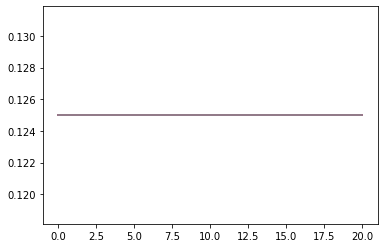

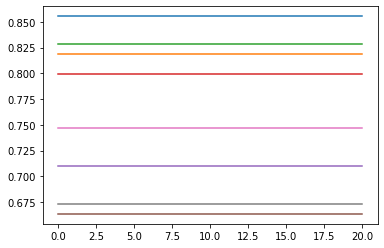

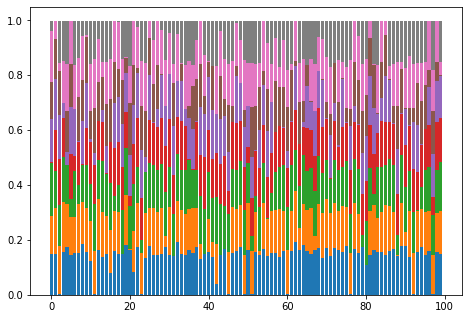

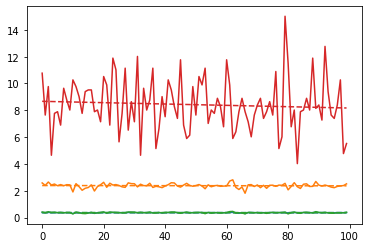

In [194]:
nonstatic_sol(100, rewards_bias, 0.0, instances_nonbias, 0.0, 0)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8679, 0.8269, 0.8182, 0.7642, 0.6852, 0.734, 0.7451, 0.7717]
Presence of each in batch (%): [13.3, 13.0, 11.0, 13.3, 13.5, 11.7, 12.7, 11.5]
Relative approval rate (%): [79.7, 80.0, 80.0, 79.7, 80.0, 80.34, 80.31, 80.0]
Percentage over total selected (%): [13.23, 12.98, 10.99, 13.23, 13.48, 11.74, 12.73, 11.49]
Total reward: 62200 || and presence bias: 0.0026367041198502167
Rate bias: 0.012860133374016702
Posteriors bias: 0.06491885143570537
Final regret: 7.8970661672908875
99
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.9293, 0.7941, 0.8455, 0.8105, 0.7059, 0.5909, 0.7807, 0.7667]
Presence of each in batch (%): [12.4, 12.7, 13.8, 11.9, 12.8, 11.0, 14.2, 11.2]
Relative approval rate (%): [79.84, 80.31, 79.71, 79.83, 79.69, 80.0, 80.28, 80.36]
Percentage over total selected (%): [12.36, 12.73, 13.73, 11.86, 12.73, 10.99,

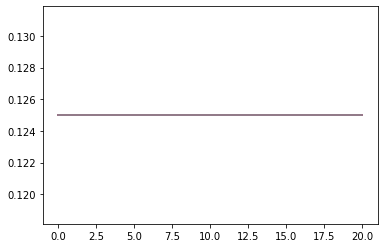

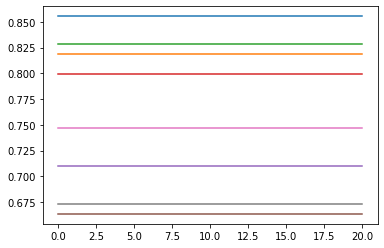

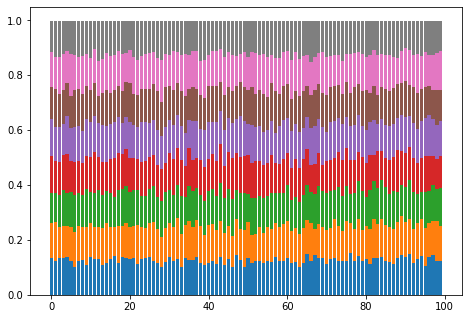

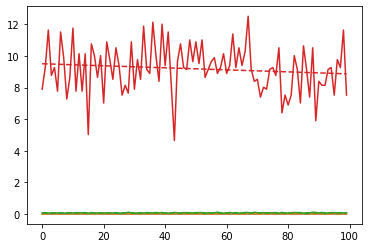

In [188]:
nonstatic_sol(100, rewards_bias, 0.0, instances_nonbias, 0.0, 0.99)

0
Reward distribution: [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
Final estimates: [0.7887, 0.8306, 0.8034, 0.8615, 0.784, 0.75, 0.8034, 0.0]
Presence of each in batch (%): [14.2, 12.4, 11.7, 13.0, 12.5, 12.7, 11.7, 11.8]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 34.65, 100.0, 0.85]
Percentage over total selected (%): [17.73, 15.48, 14.61, 16.23, 15.61, 5.49, 14.61, 0.12]
Total reward: 64700 || and presence bias: 0.37639200998751554
Rate bias: 2.467603096223142
Posteriors bias: 0.38701622971285893
Final regret: -0.7740324594257117
99
Reward distribution: [0.7983, 0.8047, 0.8069, 0.8053, 0.8047, 0.7866, 0.7951, 0.7976]
Final estimates: [0.7544, 0.8246, 0.0, 0.7877, 0.8103, 0.7547, 0.7982, 0.7958]
Presence of each in batch (%): [11.4, 11.4, 14.5, 14.6, 11.6, 10.9, 11.4, 14.2]
Relative approval rate (%): [100.0, 100.0, 0.69, 100.0, 100.0, 48.62, 100.0, 100.0]
Percentage over total selected (%): [14.23, 14.23, 0.12, 18.23, 14.48, 6.62, 14.23, 17.73]
Total reward: 63400 

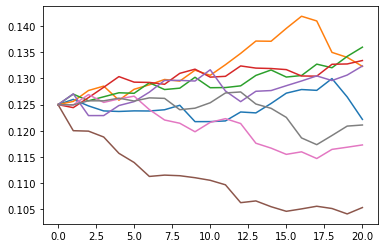

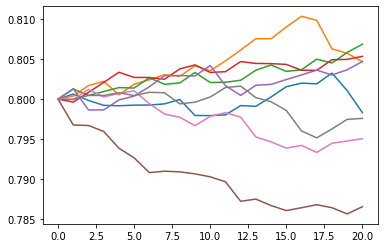

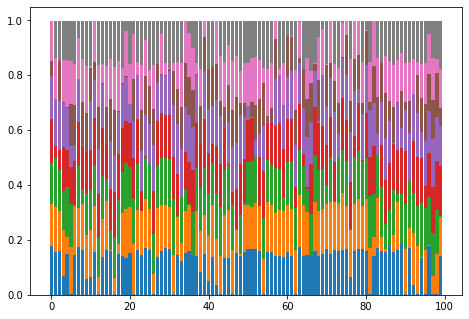

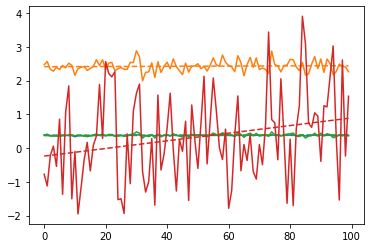

In [210]:
nonstatic_sol(100, rewards_nonbias, 0.01, instances_nonbias, 0.1, 0)

0
Reward distribution: [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
Final estimates: [0.7807, 0.8298, 0.8173, 0.8257, 0.8526, 0.7952, 0.7556, 0.7838]
Presence of each in batch (%): [14.2, 11.8, 13.0, 13.6, 11.8, 10.4, 11.3, 13.9]
Relative approval rate (%): [80.28, 79.66, 80.0, 80.15, 80.51, 79.81, 79.65, 79.86]
Percentage over total selected (%): [14.23, 11.74, 12.98, 13.61, 11.86, 10.36, 11.24, 13.86]
Total reward: 64500 || and presence bias: 0.0032559300873907515
Rate bias: 0.019663814767721055
Posteriors bias: 0.09488139825218479
Final regret: -0.5243445692883881
99
Reward distribution: [0.7999, 0.7998, 0.7999, 0.7999, 0.7999, 0.7999, 0.7999, 0.7999]
Final estimates: [0.8265, 0.8165, 0.8039, 0.7778, 0.8696, 0.8519, 0.7959, 0.766]
Presence of each in batch (%): [12.3, 13.6, 12.8, 12.4, 11.5, 13.5, 12.2, 11.7]
Relative approval rate (%): [79.67, 80.15, 79.69, 79.84, 80.0, 80.0, 80.33, 80.34]
Percentage over total selected (%): [12.23, 13.61, 12.73, 12.36, 11.49, 13.48, 12.23, 11.74]
Tota

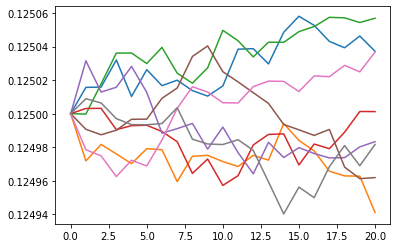

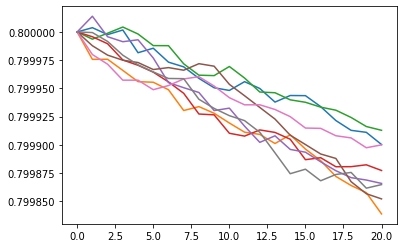

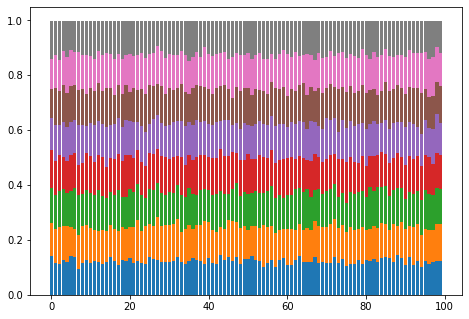

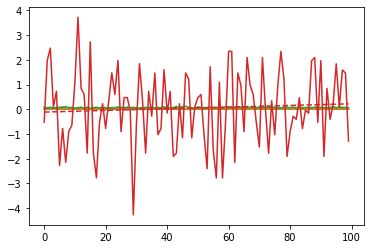

In [211]:
nonstatic_sol(100, rewards_nonbias, 0.01, instances_nonbias, 0.1, 0.5)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.0, instances_bias, 0.0, 0)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.25)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.30)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.35)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.40)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8387, 0.8026, 0.7778, 0.5, 0.75, 0.0, 0.8571, 0.5]
Presence of each in batch (%): [52.7, 22.8, 2.7, 0.6, 9.7, 10.3, 0.7, 0.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 33.33, 4.12, 0.97, 100.0, 80.0]
Percentage over total selected (%): [65.79, 28.46, 3.37, 0.25, 0.5, 0.12, 0.87, 0.5]
Total reward: 65800 || and presence bias: 0.3932858926342072
Rate bias: 3.119651019250659
Posteriors bias: 1.3857677902621721
Final regret: 3.402684144818977
99
Reward distribution: [0.9725, 0.672, 0.6738, 0.6329, 0.5072, 0.4198, 0.6002, 0.5373]
Final estimates: [0.9717, 0.6667, 1.0, 0.6667, 0.0, 0.6667, 0.75, 0.5]
Presence of each in batch (%): [86.5, 5.9, 0.6, 0.5, 3.9, 1.9, 0.4, 0.3]
Relative approval rate (%): [89.94, 5.08, 100.0, 60.0, 2.56, 15.79, 100.0, 66.67]
Percentage over total selected (%): [97.13, 0.37, 0.75, 0.37, 0.12, 0.37, 0.5, 0.25]
Total reward: 77300 || and presence bias: 

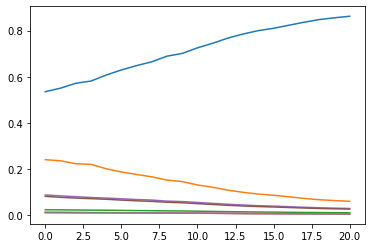

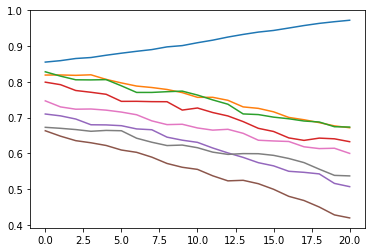

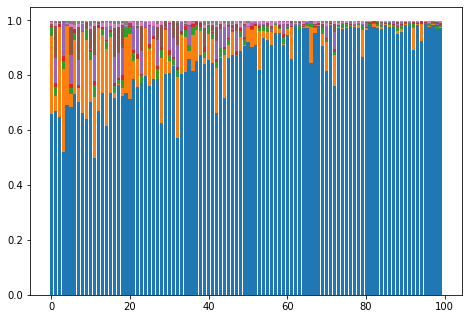

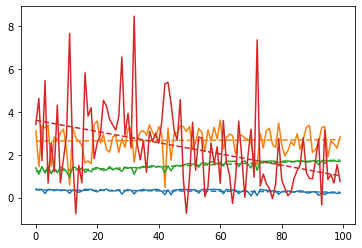

In [246]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.0)

In [ ]:
nonstatic_sol(100, rewards_bias, 0.01, instances_bias, 0.1, 0.5)

In [45]:
def max_per_step(tr):
  indexes = [0]*len(tr[0])
  reward = 0
  for i in range(len(tr[0])):
    candidates = []
    for j in range(len(tr)):
      candidates.append(tr[j][indexes[j]])
    max_i = random_argmax(candidates)
    reward += tr[max_i][indexes[max_i]]
    indexes[max_i]+=1
    #print(max_i)
  return reward*100

In [97]:
l = [[]]*2
l[0].append(1)
print(l)

[[1], [1]]


In [104]:
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
#print(len(decisions))
true_rewards = []
for i in range(8):
  true_rewards.append([])
for d in decisions:
  true_rewards[d].append(np.random.binomial(1,list(rewards_bias)[d]))
  #print([len(true_rewards[j]) for j in range(len(true_rewards))])

In [111]:
#max=0
#for i in range(10):
#  v = max_per_step(true_rewards)
#  if v>max:
#    max=v

total=0
for g in true_rewards:
  #print(g)
  total += sum(g)
print(total*100)

82900


In [35]:
def nonstatic_sol_true(iter, rewards_d_o_mu, r_coef, instances_d_o, i_coef, sub_opt):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  rewards_his = []
  instances_hist = [] 
  percentages_hist = []
  bias_hist = []

  for i in range(iter):
    pbool=False
    #if(i%math.ceil(iter/4)==0 or i==iter-1):
    if(i==0 or i==iter-1):
        print(i)
        pbool=True

    if(i%math.ceil(iter/20)==0 or i==iter-1):
      rewards_his.append(rewards_d)
      instances_hist.append(instances_d)

    decisions = random.choices(range(8),weights=list(instances_d),k=1000)
    true_rewards = [[]]*8
    for d in decisions:
      true_rewards[d].append(np.random.binomial(1,list(rewards_d)[d]))

    updated_test = SocketTesterBatchSOLUTIONProb(PowerSocketTrue, true_rewards, 10, sub_opt)
    rd = updated_test.run(decisions, 0.8, pbool)

    #if(i%math.ceil(iter/25)==0 or i==iter-1):
    percentages_hist.append(rd["percentages"])

    bias_hist.append([rd["bias_presence"],rd["bias_rate"],rd["bias_posteriors"]])

    r_update = rd["estimates"]
    i_update = rd["increments"]
    
    old_r_term = np.multiply(rewards_d,1-r_coef)
    #new_r_term = np.multiply(r_update,r_coef)
    new_r_term = np.multiply(np.multiply(r_update,i_update),r_coef)
    rewards_d = np.add(old_r_term,new_r_term)
    rewards_d = np.clip(rewards_d,0,0.99)

    old_i_term = np.multiply(instances_d,1-i_coef)
    new_i_term = np.multiply(np.multiply(instances_d,i_update),i_coef)
    instances_d = np.add(old_i_term,new_i_term)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()
  
  plot_values(instances_hist)
  plot_values(rewards_his)
  plot_percen(percentages_hist)
  plot_values(bias_hist, True)
  #return rewards_his, instances_hist

0
Final estimates: [0.8355, 0.8229, 1.0, 1.0, 0.7714, 0.8103, 1.0, 1.0]
Presence of each in batch (%): [57.0, 24.0, 1.7, 0.7, 8.8, 7.3, 0.2, 0.3]
Relative approval rate (%): [80.0, 80.0, 76.47, 85.71, 79.55, 79.45, 100.0, 100.0]
Percentage over total selected (%): [56.93, 23.97, 1.62, 0.75, 8.74, 7.24, 0.25, 0.37]
Total reward: 66500 || and presence bias: 0.00471410736579274
Rate bias: 0.6054178396140524
Posteriors bias: 1.118601747815231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in double_scalars


99
Final estimates: [0.8288, 0.8286, 0.8, 0.7143, 0.7759, 0.7846, 0.0, 0.0]
Presence of each in batch (%): [55.4, 26.2, 1.9, 0.9, 7.2, 8.1, 0.0, 0.3]
Relative approval rate (%): [80.14, 80.15, 78.95, 77.78, 80.56, 80.25, 0.0, 33.33]
Percentage over total selected (%): [55.43, 26.22, 1.87, 0.87, 7.24, 8.11, 0.0, 0.12]
Total reward: 65600 || and presence bias: 0.0033233458177277784
Rate bias: nan
Posteriors bias: nan


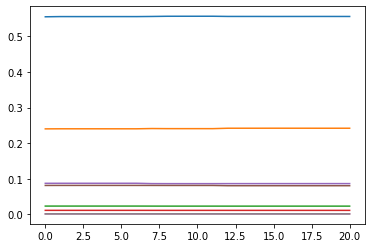

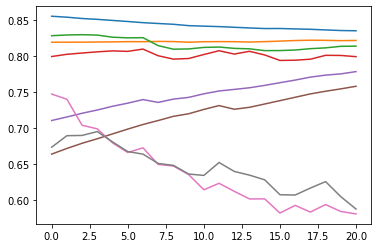

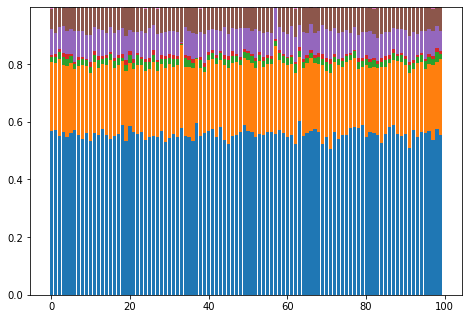

NameError: ignored

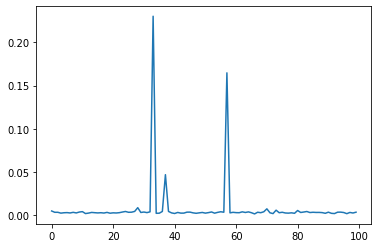

In [36]:
nonstatic_sol_true(100, rewards_bias, 0.01, instances_bias, 0.1, 0.40)

In [ ]:
variances = [10]*8
##(5000 per iter)
nonstatic_sol(1000, rewards_bias, 0.02, instances_bias, 0.02, 0.1, variances)

In [ ]:
variances = [10]*8
nonstatic_sol(1000, rewards_bias, 0.04, instances_bias, 0.04, 100, variances)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)

unpickled_df = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_AL-GA_actions_taken_1-3.csv")
print(unpickled_df.derived_sex.unique(),'\n',
unpickled_df.derived_race.unique(),'\n',
unpickled_df.derived_ethnicity.unique(),'\n',
unpickled_df.action_taken.unique())

subsample = unpickled_df                    

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==3]))
subsample = subsample.loc[subsample["action_taken"].isin([1,3])]
subsample["action_taken"] = subsample["action_taken"].replace([3],[0])    
print("action:",subsample["action_taken"].unique())
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print("race pre:",subsample["derived_race"].unique())
subsample = subsample.loc[subsample["derived_race"].isin(["White","Black or African American"])]
subsample["derived_race"] = subsample["derived_race"].replace(["White","Black or African American"],[0,1])
print("race:",subsample["derived_race"].unique())

print("ethnicity pre:",subsample["derived_ethnicity"].unique())
subsample = subsample.loc[subsample["derived_ethnicity"].isin(['Not Hispanic or Latino','Hispanic or Latino'])]
subsample["derived_ethnicity"] = subsample["derived_ethnicity"].replace(['Not Hispanic or Latino','Hispanic or Latino'],[0,1])
print("ethnicity:",subsample["derived_ethnicity"].unique())

print("sex pre",subsample["derived_sex"].unique())
subsample = subsample.loc[subsample["derived_sex"].isin(['Male','Female'])]
subsample["derived_sex"] = subsample["derived_sex"].replace(['Male','Female'],[0,1])
print("sex:",subsample["derived_sex"].unique())


subsample = subsample.loc[subsample["interest_rate"]!='Exempt']
subsample["interest_rate"] = pd.to_numeric(subsample["interest_rate"] ) 

#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
subsample = subsample.loc[subsample["loan_to_value_ratio"]!='Exempt']
#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
#print(subsample["loan_to_value_ratio"])
subsample["loan_to_value_ratio"] = pd.to_numeric(subsample["loan_to_value_ratio"] )  
#print(subsample["loan_to_value_ratio"].mean())

subsample = subsample.loc[subsample["property_value"]!='Exempt']
subsample["property_value"] = pd.to_numeric(subsample["property_value"] ) 

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print(len(subsample))
#subsample = subsample[["loan_type", "property_type", "loan_purpose", "loan_amount_000s",
#                            "action_taken","applicant_ethnicity","applicant_race_1","applicant_sex",
#                           "applicant_income_000s"]]
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())

#thr=0.25
#for col in subsample.columns:
#  if (subsample[col].isnull().sum()>thr*len(subsample)):
    #subsample.drop(columns=[col])
#    print(col)

#subsample = subsample.dropna(axis=1,thresh=thr*len(subsample))
#subsample = subsample.dropna(axis=0)

# Iterate over each column of cc_apps
for col in subsample.columns:
    # Check if the column is of object type
    if subsample[col].dtypes == 'object':
        # Impute with the most frequent value
        subsample = subsample.fillna(subsample[col].value_counts().index[0])


print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

# Count the number of NaNs in the dataset and print the counts to verify
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())
cols = [f_ for f_ in subsample.columns if subsample[f_].dtype != 'object']
features = cols

list_to_remove = ['action_taken','purchaser_type', 'activity_year',
                  'denial_reason_1','denial_reason_2','denial_reason_3','sequence_number','application_date_indicator']

features = list(set(cols).difference(set(list_to_remove)))

X = subsample[features]
y = subsample['action_taken']

# Import train_test_split
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.3,
                                random_state=2)

X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test,
                                y_test,
                                test_size=0.33,
                                random_state=2)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)
rescaledX_test1 = scaler.fit_transform(X_test1)
rescaledX_test2 = scaler.fit_transform(X_test2)

logreg = LogisticRegression(solver="liblinear")

scores_dict = cross_validate(logreg,rescaledX_train,y_train,cv=5, return_estimator=True)
best = scores_dict["estimator"][0] 


y_pred = best.predict(rescaledX_test1)
from collections import Counter
counterpred = Counter(y_pred)
countertest = Counter(y_test1)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test1, y_test1))


y_pred = best.predict(rescaledX_test2)
counterpred = Counter(y_pred)
countertest = Counter(y_test2)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test2, y_test2))

/content/drive
Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['Male' 'Female' 'Joint' 'Sex Not Available'] 
 ['Asian' 'White' 'Black or African American' 'Race Not Available'
 '2 or more minority races' 'Joint' 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Free Form Text Only'] 
 ['Not Hispanic or Latino' 'Hispanic or Latino' 'Ethnicity Not Available'
 'Joint' 'Free Form Text Only'] 
 [1 3]
637571 150977
action: [1 0]
637571 150977
race pre: ['Asian' 'White' 'Black or African American' 'Race Not Available'
 '2 or more minority races' 'Joint' 'American Indian or Alaska Native'
 'Native Hawaiian or Other Pacific Islander' 'Free Form Text Only']
race: [0 1]
ethnicity pre: ['Not Hispanic or Latino' 'Hispanic or Latino' 'Joint'
 'Ethnicity Not Available' 'Free Form Text Only']
ethnicity: [0 1]
sex pre ['Female' 'Joint' 'Male' 'Sex Not Available']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sex: [1 0]
297078 77133
374211
297078 77133
374211 99 11416911
297078 77133
374211 99 0
Counter({1: 59048, 0: 16168}) Counter({1: 59642, 0: 15574}) Counter({1: 297078, 0: 77133})
Accuracy of logistic regression classifier:  0.9767602637736652
Counter({1: 29269, 0: 7779}) Counter({1: 29505, 0: 7543}) Counter({1: 297078, 0: 77133})
Accuracy of logistic regression classifier:  0.9764089829410495


In [11]:
import math
def partitions(n_partitions, X, y):
  X_partitions = []
  y_partitions = []
  size_partitions = math.floor(len(X)/n_partitions)
  for p in range(n_partitions):
    X_partitions.append(X[p*size_partitions:(p+1)*size_partitions])  
    y_partitions.append(y[p*size_partitions:(p+1)*size_partitions])
  print(len(X), [sum(len(item) for item in X_partitions)], len(X_partitions[0]))
  return X_partitions, y_partitions

In [12]:
def create_df(x,xcol,y,ycol):
  auxnparray = x.copy()
  newdf = pd.DataFrame(auxnparray, columns = xcol)
  newdf[ycol] = y.tolist()
  return newdf

In [13]:
def preproc(df):
  subgroups = []
  instances = []
  sensitive = ["derived_race","derived_ethnicity","derived_sex"]
  R = ["W","B"]
  E = ["NH","H"]
  S = ["M","F"]
  for option in [0,1]:
    for option2 in [0,1]:
      for option3 in [0,1]:
          subgroups.append(df.loc[((df[sensitive[0]]==option) & (df[sensitive[1]]==option2) & (df[sensitive[2]]==option3))])
          instances.append(len(subgroups[-1]))
  return subgroups, instances

In [14]:
from scipy.stats import norm

df = create_df(X,features,y,"action_taken")

mean1, std1 = norm.fit(df.loc[df["action_taken"]==1.0]["loan_amount"])

mean0, std0 = norm.fit(df.loc[df["action_taken"]==0.0]["loan_amount"])

print(mean1, std1)
print(mean0, std0)
print()
sg, ic = preproc(df)
for s in sg:
  approval_rate = len(s.loc[s["action_taken"]==1.0])/len(s)
  print(approval_rate)
  mu, std = norm.fit(s["loan_amount"])
  print(mu,std)

218105.0431199887 139481.95009278832
160005.25067091905 1105860.4324265125

0.8351500209501023
226709.22472476424 166779.32726755406
0.8159538417240692
188992.66871913 1018094.2364840672
0.817375020354991
210144.11333659012 117534.09872909547
0.7888888888888889
188379.08496732026 97116.36484512454
0.7132048203013751
199465.57990265882 124702.33091446564
0.6970787386341653
178265.8154381892 140000.80131986627
0.6884939195509823
200051.4499532273 117415.7428144394
0.6611328125
184667.96875 101521.08342728137


In [15]:
class PowerSocketReal:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        # value = self.var * np.random.randn() + self.q      

        #value = self.q.iloc[self.n]["action_taken"]

        #value = self.q["action_taken"].sample(n=1).iloc[0]

        sample = self.q.sample(n=1)
        if (sample["action_taken"].iloc[0]==1.0):
          value = sample["loan_amount"].iloc[0]
        else:
          value = 0.0

        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [16]:
class SocketTesterBatchReal():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*sum(class_count))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [17]:
class SocketTesterBatchRealBudget():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward  
        self.budget -= reward 
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, budget, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        self.budget = budget
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
            if self.budget-max(self.get_estimates()[t]) < 0:
              break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [18]:
real_test = SocketTesterBatchReal(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(4,X,y)
for b in range(4):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8, True)

[<__main__.PowerSocketReal object at 0x7fcdccb8c410>, <__main__.PowerSocketReal object at 0x7fcdbc510290>, <__main__.PowerSocketReal object at 0x7fcdbc510190>, <__main__.PowerSocketReal object at 0x7fcdbc5103d0>, <__main__.PowerSocketReal object at 0x7fcdbc510390>, <__main__.PowerSocketReal object at 0x7fcdbc510110>, <__main__.PowerSocketReal object at 0x7fcdbb9a4950>, <__main__.PowerSocketReal object at 0x7fcdbb9a47d0>]
374211 [374208] 93552
[42794, 24167, 2587, 1290, 10272, 11956, 247, 239]
Presence of each in batch (%): [45.74354369762271, 25.832691978792543, 2.7653069950401914, 1.37891226269882, 10.979989738327347, 12.780058149478364, 0.26402428595861127, 0.2554728920814093]
Relative approval rate (%): [100.0, 100.0, 0.08, 0.54, 76.07, 0.03, 1.21, 21.34]
Percentage over total selected (%): [57.18, 32.29, 0.0, 0.01, 10.44, 0.0, 0.0, 0.07]
[41555, 23760, 2801, 1374, 10993, 12635, 213, 221]
Presence of each in batch (%): [44.41914657089106, 25.397639815289892, 2.9940567812553445, 1.46

In [19]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(10,X,y)
for b in range(10):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  budget = batch["loan_amount"].sum()
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8*budget, True)

[<__main__.PowerSocketReal object at 0x7fcdccadb450>, <__main__.PowerSocketReal object at 0x7fcdccadb090>, <__main__.PowerSocketReal object at 0x7fcdccadb910>, <__main__.PowerSocketReal object at 0x7fcdccadb490>, <__main__.PowerSocketReal object at 0x7fcdccadb710>, <__main__.PowerSocketReal object at 0x7fcdccadb410>, <__main__.PowerSocketReal object at 0x7fcdccadb190>, <__main__.PowerSocketReal object at 0x7fcdccadb150>]
374211 [374210] 37421
[17513, 9964, 917, 466, 3822, 4585, 76, 78]
Presence of each in batch (%): [46.799925175703486, 26.6267603751904, 2.450495710964432, 1.2452900777638225, 10.213516474706715, 12.252478554822158, 0.20309451912028006, 0.2084391117287085]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 35.92, 100.0, 100.0, 100.0]
Percentage over total selected (%): [50.08, 28.49, 2.62, 1.33, 3.93, 13.11, 0.22, 0.22]
[17570, 9529, 1072, 501, 4058, 4485, 105, 101]
Presence of each in batch (%): [46.952246065043695, 25.46431148285722, 2.8647016381176345, 1.338820

KeyboardInterrupt: ignored

In [ ]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(1,X,y)
for b in range(1):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  #budget = batch["loan_amount"].sum()
  budget=0
  sg, ic = preproc(batch)
  min_amount = min(ic)
  for s in range(len(sg)):
    sg[s] = sg[s].sample(n=min_amount)
    budget += sg[s]["loan_amount"].sum()
  ts,tr,ti = real_test.run(sg, [min_amount]*8, 0.8*budget, True)